#Instalación de las dependencias

In [0]:
!pip3 install -q robobrowser
import re
from robobrowser import RoboBrowser
from IPython.display import Image, HTML, display
from collections import namedtuple
import json
import os

Fallo = namedtuple('Fallo',['nombre','informacion'])

In [0]:
def pasar_pagina(form, pagina=0):
  form['paginado'].value = 1
  form['pagina'].value = pagina
  browser.submit_form(form)
  return

def descargar(file_path,link):
  request = browser.session.get(link, stream=True)
  with open(file_path, "wb") as pdf_file:
    pdf_file.write(request.content)
  return

def extraer_informacion(resultado=None):
  texto = resultado.find_all('li')
  informacion = {'link': 'http://cij.gov.ar/' + \
                  resultado.find(class_="download")["href"]}
  for linea in texto:
    campo, info = tuple(t.strip() for t in linea.text.split(':',1))
    informacion[campo] = info
  return informacion

def extraer_fallos(browser=None,form=None,file_data=[],\
                   output_dir='./',download=False):
  
  fallos_totales = int(browser.find(class_="s1").text)
  n_paginas = fallos_totales // 20 # CIJ muestra 20 resultados por página 
  paginas = (i for i in range(n_paginas+1))
  nro_fallo = (i for i in range(1,fallos_totales+1))
  
  for pagina in paginas:
    pasar_pagina(form,pagina)
    resultados = browser.find_all(class_="result")
    assert len(resultados) > 0
    
    for resultado in resultados:
      nro_archivo = next(nro_fallo)
      filename = output_dir + 'fallo_{:04d}.pdf'.format(nro_archivo)
      informacion = extraer_informacion(resultado)
      if download:       
        descargar(filename,informacion['link'])
      fallo = Fallo(filename,informacion)
      file_data.append(fallo)

    print("\r[{0}] {1:d}/{2:d}".format('='*int(60*nro_archivo/fallos_totales),\
                                       nro_archivo,fallos_totales),end=' ')
#     print("\r",end='') # Activar para que muestre bien (depende del Notebook)
  if download:
    print('Se descargaron: ',nro_archivo,' de los ',fallos_totales)
  else:
    print('Se extrajo la información de: ',nro_archivo,' de los ',fallos_totales)
    
  return
  # Agregar la posibilidad de un nro máximo de descargas

#Descarga de los archivos

Abrimos la conexión con la página

In [3]:
browser = RoboBrowser(history=True)
browser.open('http://cij.gov.ar/sentencias.html')

# Pedimos el formulario
form = browser.get_form(id='fallos')
# form

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


Consultamos el captcha para realizar la consulta

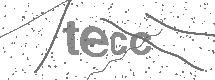

Insertar el texto del captcha: tecc


In [4]:
url_captcha = 'http://cij.gov.ar/lib/securimage/securimage_show.php'
request = browser.session.get(url_captcha, stream=True)
display(Image(request.content))
captcha_value = input('Insertar el texto del captcha: ')

## Requerimos los parámetros de la búsqueda

In [7]:
for i,x in enumerate(form['jurisdiccion'].labels):
    print('{:2d} : {:}'.format(i,x))
jurisdiccion = input('Elegir jurisdicción (Ej: 3 para Chaco): ')
fecha_desde = input('Fecha desde (Ej: 2008-01-01): ')
fecha_hasta = input('Fecha desde (Ej: 2018-01-01): ')
palabras_clave = input('Palabras clave: ')

 0 : Indistinta
 1 : Buenos Aires
 2 : Catamarca
 3 : Chaco
 4 : Chubut
 5 : Capital Federal
 6 : Córdoba
 7 : Corrientes
 8 : Entre Ríos
 9 : Formosa
10 : Jujuy
11 : La Pampa
12 : La Rioja
13 : Mendoza
14 : Misiones
15 : Neuquén
16 : Río Negro
17 : Salta
18 : San Juan
19 : San Luis
20 : Santa Cruz
21 : Santa Fe
22 : Santiago del Estero
23 : Tierra del Fuego
24 : Tucumán
Elegir jurisdicción (Ej: 3 para Chaco): 5
Fecha desde (Ej: 2008-01-01): 
Fecha desde (Ej: 2018-01-01): 2018-03-05
Palabras clave: violencia de genero


In [9]:
# display(HTML(''.join(str(x) for x in form.parsed.contents)))

form['jurisdiccion'].value = form['jurisdiccion'].labels[int(jurisdiccion)] \
                              if len(jurisdiccion) else 'Capital Federal'
form['fecha_fallo_desde'].value = fecha_desde if len(fecha_desde) else '2008-01-01'
form['fecha_fallo_hasta'].value = fecha_hasta if len(fecha_hasta) else '2018-12-31'
form['firmantes'].value = palabras_clave if len(palabras_clave) else ''
form['captcha_code'].value = captcha_value

#Resumen de la consulta
for key in form.fields:
  print(key, ':', form[key].value)

acc : searchFallos
tipo : fallo
paginado : 0
pagina : 0
jurisdiccion : 5-5
expediente : 
tid : 
caratula : 
objetos_delitos : 
fecha_fallo_desde : 2008-01-01
fecha_fallo_desde_aux : 05/02/2018
fecha_fallo_hasta : 2018-03-05
fecha_fallo_hasta_aux : 06/04/2018
firmantes : violencia de genero
tipofallo : 
captcha_code : tecc


In [10]:
# browser.submit_form(form)
# print('Cantidad de fallos: ',int(browser.find(class_="s1").text))
metadata_busqueda = {
    'fallos_totales':int(browser.find(class_="s1").text),
    'palabras_clave':palabras_clave,
    'tipo_fallo':form['tipofallo'].value,
    'jurisdiccion':form['jurisdiccion'].labels[int(jurisdiccion)],
    'tribunal':form['tid'].value,
    'expediente':form['expediente'].value,
    'caratula':form['caratula'].value,
    'fecha_desde':fecha_desde,
    'fecha_hasta':fecha_hasta
}
print(metadata_busqueda)

{'fallos_totales': 37209, 'palabras_clave': 'violencia de genero', 'tipo_fallo': '', 'jurisdiccion': 'Capital Federal', 'tribunal': '', 'expediente': '', 'caratula': '', 'fecha_desde': '', 'fecha_hasta': '2018-03-05'}


In [0]:
# Agregar el try a este tipo derrores
# x = form['jurisdiccion']
# x.value = 'Ia'
# x.value

In [20]:
file_data = []
output_directory='./pdf_fallos/'

try:
  os.stat(output_directory)
except:
  os.mkdir(output_directory)


extraer_fallos(browser=browser, form=form, file_data=file_data,
                           output_dir=output_directory,
                           download=True)
len(file_data)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


[=] 40/1355 

KeyboardInterrupt: ignored

In [0]:
#Guardamos la información de los fallos y la metadata de la búsqueda
with open(output_directory + 'metadata_busqueda.json','w') as f:
    json.dump(metadata_busqueda,f)
with open(output_directory + 'info_fallos.json','w') as f:
    json.dump([x._asdict() for x in file_data],f)

Si se corre en Colab, los datos descargados se van a eliminar una vez cerrada la sesión
por lo que es necesario o descargarlos en la PC o subirlos a algún lugar.

# Para guardar los datos en Google Drive

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = 'REPLACE_WITH_YOUR_FILE_ID'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [0]:
file2 = drive.CreateFile()
file2.SetContentFile('file.pdf')
file2['title'] = 'un_archivo_de_prueba.pdf' 
file2.Upload()
print('Created file %s with mimeType %s' % (file2['title'],
file2['mimeType']))

# Para bajar los datos a la maquina local

In [0]:
from google.colab import files

with open('example.txt', 'w') as f:
  f.write('some content')

files.download('example.txt')

# Análisis 

In [13]:
!pip install pdfplumber
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pdfplumber as pdfp

pd.options.display.max_rows = 10
sns.set()

    100% |████████████████████████████████| 12.0MB 114kB/s 
    100% |████████████████████████████████| 6.9MB 202kB/s 
    100% |████████████████████████████████| 71kB 5.4MB/s 
  Running setup.py bdist_wheel for pdfplumber ... - \ done
  Stored in directory: /content/.cache/pip/wheels/85/33/4d/5e7cec0bc0700a0ab0c02481317a98b59f84b59b283f94299e
  Running setup.py bdist_wheel for pdfminer.six ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/92/af/bf/158b037892b25aa7768ce93127397530910704ad8e2f15f67f
  Running setup.py bdist_wheel for unicodecsv ... - done
  Stored in directory: /content/.cache/pip/wheels/97/e2/16/219fa93b83edaff912b6805cfa19d0597e21f8d353f3e2d22f
  Running setup.py bdist_wheel for wand ... - \ done
  Stored in directory: /content/.cache/pip/wheels/18/40/0d/27d632088ea23dfb9a275da88e26bd992fd01b4e03a81ce5e2
Successfully built pdfplumber pdfminer.six unicodecsv wand


In [14]:
df = pd.DataFrame([file.informacion for file in file_data])
df

,Carátula,Expediente N°,Fecha de sentencia,Tribunal,link
0,Principal en Tribunal Oral TO01 - IMPUTADO: FL...,CCC 019457/2016/TO01,02/03/2018,TRIBUNAL ORAL EN LO CRIMINAL Y CORRECCIONAL NR...,http://cij.gov.ar/scp/include/showFile.php?acc...
1,Principal en Tribunal Oral TO01 - IMPUTADO: ES...,CCC 016372/2017/TO01,02/03/2018,TRIBUNAL ORAL EN LO CRIMINAL Y CORRECCIONAL NR...,http://cij.gov.ar/scp/include/showFile.php?acc...
2,Principal en Tribunal Oral TO01 - IMPUTADO: AL...,CCC 011646/2017/TO01,01/03/2018,TRIBUNAL ORAL EN LO CRIMINAL Y CORRECCIONAL NR...,http://cij.gov.ar/scp/include/showFile.php?acc...
3,Principal en Tribunal Oral TO01 - IMPUTADO: PI...,FCB 053170044/2011/TO01/CFC001,01/03/2018,CAMARA FEDERAL DE CASACION PENAL - SALA 1,http://cij.gov.ar/scp/include/showFile.php?acc...
4,Principal en Tribunal Oral TO01 - IMPUTADO: AL...,CCC 017522/2016/TO01,28/02/2018,TRIBUNAL ORAL EN LO CRIMINAL Y CORRECCIONAL NR...,http://cij.gov.ar/scp/include/showFile.php?acc...
...,...,...,...,...,...
55,Principal en Plenario PL02 - IMPUTADO: GALINDO...,CCC 021486/2014/PL02/CNC001,21/12/2017,CÁMARA NACIONAL DE CASACIÓN EN LO CRIMINAL Y C...,http://cij.gov.ar/scp/include/showFile.php?acc...
56,Principal en Tribunal Oral TO01 - IMPUTADO: MA...,CCC 066438/2014/TO01,21/12/2017,TRIBUNAL ORAL EN LO CRIMINAL Y CORRECCIONAL NR...,http://cij.gov.ar/scp/include/showFile.php?acc...
57,Principal en Tribunal Oral TO01 - IMPUTADO: VI...,CCC 037100/2013/TO01,19/12/2017,TRIBUNAL ORAL EN LO CRIMINAL Y CORRECCIONAL NR...,http://cij.gov.ar/scp/include/showFile.php?acc...
58,Principal en Tribunal Oral TO01 - IMPUTADO: CH...,CCC 004195/2002/TO01,19/12/2017,TRIBUNAL ORAL EN LO CRIMINAL Y CORRECCIONAL NR...,http://cij.gov.ar/scp/include/showFile.php?acc...


In [15]:
df['Fecha de sentencia'].value_counts()

28/12/2017    5
23/02/2018    5
27/12/2017    5
26/12/2017    4
28/02/2018    3
             ..
18/12/2017    1
26/02/2018    1
12/01/2018    1
27/02/2018    1
08/02/2018    1
Name: Fecha de sentencia, Length: 28, dtype: int64

## Análisis de un archivo pdf 

In [0]:
from pprint import PrettyPrinter
pprint = PrettyPrinter().pprint

In [32]:
!ls pdf_fallos/

fallo_0001.pdf	fallo_0013.pdf	fallo_0025.pdf	fallo_0037.pdf
fallo_0002.pdf	fallo_0014.pdf	fallo_0026.pdf	fallo_0038.pdf
fallo_0003.pdf	fallo_0015.pdf	fallo_0027.pdf	fallo_0039.pdf
fallo_0004.pdf	fallo_0016.pdf	fallo_0028.pdf	fallo_0040.pdf
fallo_0005.pdf	fallo_0017.pdf	fallo_0029.pdf	fallo_0041.pdf
fallo_0006.pdf	fallo_0018.pdf	fallo_0030.pdf	fallo_0042.pdf
fallo_0007.pdf	fallo_0019.pdf	fallo_0031.pdf	fallo_0043.pdf
fallo_0008.pdf	fallo_0020.pdf	fallo_0032.pdf	fallo_0044.pdf
fallo_0009.pdf	fallo_0021.pdf	fallo_0033.pdf	info_fallos.json
fallo_0010.pdf	fallo_0022.pdf	fallo_0034.pdf	metadata_busqueda.json
fallo_0011.pdf	fallo_0023.pdf	fallo_0035.pdf
fallo_0012.pdf	fallo_0024.pdf	fallo_0036.pdf


In [0]:
pdf = pdfp.open(path='./pdf_fallos/fallo_0003.pdf')

In [33]:
first_page = pdf.pages[0]
# pprint(first_page.chars[0])
# pprint(first_page.extract_text())
pprint(first_page.extract_words())

[{'bottom': Decimal('84.524'),
  'text': 'Poder',
  'top': Decimal('66.548'),
  'x0': Decimal('272.300'),
  'x1': Decimal('304.948')},
 {'bottom': Decimal('84.524'),
  'text': 'Judicial',
  'top': Decimal('66.548'),
  'x0': Decimal('308.476'),
  'x1': Decimal('351.946')},
 {'bottom': Decimal('84.524'),
  'text': 'de',
  'top': Decimal('66.548'),
  'x0': Decimal('355.460'),
  'x1': Decimal('368.662')},
 {'bottom': Decimal('84.524'),
  'text': 'la',
  'top': Decimal('66.548'),
  'x0': Decimal('372.162'),
  'x1': Decimal('382.256')},
 {'bottom': Decimal('84.524'),
  'text': 'Nación',
  'top': Decimal('66.548'),
  'x0': Decimal('385.756'),
  'x1': Decimal('426.146')},
 {'bottom': Decimal('101.044'),
  'text': 'TRIBUNAL',
  'top': Decimal('89.488'),
  'x0': Decimal('164.000'),
  'x1': Decimal('209.369')},
 {'bottom': Decimal('101.044'),
  'text': 'ORAL',
  'top': Decimal('89.488'),
  'x0': Decimal('211.664'),
  'x1': Decimal('236.144')},
 {'bottom': Decimal('101.044'),
  'text': 'EN',
  'to

In [34]:
!apt-get -q install imagemagick

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  dbus fontconfig fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  hicolor-icon-theme imagemagick-6-common imagemagick-6.q16 libapparmor1
  libavahi-client3 libavahi-common-data libavahi-common3 libcairo2 libcups2
  libcupsfilters1 libcupsimage2 libdatrie1 libdbus-1-3 libdjvulibre-text
  libdjvulibre21 libfftw3-double3 libgraphite2-3 libgs9 libgs9-common
  libharfbuzz0b libijs-0.35 libilmbase12 libjbig0 libjbig2dec0 liblcms2-2
  liblqr-1-0 libltdl7 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libopenexr22 libpango-1.0-0
  libpangocairo-1.0-0 libpangoft2-1.0-0 libpaper-utils libpaper1 libpixman-1-0
  libthai-data libthai0 libtiff5 libwmf0.2-7 libxcb-render0 libxcb-shm0 netpbm
  poppler-data
Suggested packages:
  default-dbus-session-bus | dbus-session-bus fonts-noto ghostscript-x
  imagemagick-doc autotr

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fontconfig.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package fonts-droid-fallback.
Preparing to unpack .../01-fonts-droid-fallback_1%3a6.0.1r16-1.1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1) ...
Selecting previously unselected package liblqr-1-0:amd64.
Preparing to unpack .../02-liblqr-1-0_0.4.2-2_amd64.deb ...
Unpacking liblqr-1-0:amd64 (0.4.2-2) ...
Selecting previously unselected package libfftw3-double3:amd64.
Preparing to unpack .../03-libfftw3-double3_3.3.6p2-1_amd64.deb ...
Unpacking libfftw3-double3:amd64 (3.3.6p2-1) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../04-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting 

Selecting previously unselected package gsfonts.
Preparing to unpack .../27-gsfonts_1%3a8.11+urwcyr1.0.7~pre44-4.3_all.deb ...
Unpacking gsfonts (1:8.11+urwcyr1.0.7~pre44-4.3) ...
Selecting previously unselected package hicolor-icon-theme.
Preparing to unpack .../28-hicolor-icon-theme_0.17-1_all.deb ...
Unpacking hicolor-icon-theme (0.17-1) ...
Selecting previously unselected package imagemagick-6.q16.
Preparing to unpack .../29-imagemagick-6.q16_8%3a6.9.7.4+dfsg-16ubuntu2_amd64.deb ...
Unpacking imagemagick-6.q16 (8:6.9.7.4+dfsg-16ubuntu2) ...
Selecting previously unselected package imagemagick.
Preparing to unpack .../30-imagemagick_8%3a6.9.7.4+dfsg-16ubuntu2_amd64.deb ...
Unpacking imagemagick (8:6.9.7.4+dfsg-16ubuntu2) ...
Selecting previously unselected package libpixman-1-0:amd64.
Preparing to unpack .../31-libpixman-1-0_0.34.0-1_amd64.deb ...
Unpacking libpixman-1-0:amd64 (0.34.0-1) ...
Selecting previously unselected package libxcb-render0:amd64.
Preparing to unpack .../32-libx

Setting up imagemagick-6-common (8:6.9.7.4+dfsg-16ubuntu2) ...
Setting up fonts-droid-fallback (1:6.0.1r16-1.1) ...
Setting up libpaper-utils (1.1.24+nmu5ubuntu1) ...
Setting up libxcb-render0:amd64 (1.12-1ubuntu1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Setting up gsfonts (1:8.11+urwcyr1.0.7~pre44-4.3) ...
Setting up liblcms2-2:amd64 (2.7-1ubuntu1) ...
Setting up libjbig0:amd64 (2.1-3.1) ...
Setting up poppler-data (0.4.8-1) ...
Setting up libdjvulibre-text (3.5.27.1-7) ...
Setting up libnetpbm10 (2:10.0-15.3build1) ...
Setting up libdatrie1:amd64 (0.2.10-5) ...
Setting up libtiff5:amd64 (4.0.8-5) ...
Setting up libfftw3-double3:amd64 (3.3.6p2-1) ...
Setting up fonts-noto-mono (20161116-1) ...
Setting up libgraphite2-3:amd64 (1.3.10-2) ...
Setting up libilmbase12:amd64 (2.2.0-11ubuntu2) ...
Setting up liblqr-1-0:amd64 (0.4.2-2) ...
Setting up libjbig2dec0:amd64 (0.13-5) ...
Setting up libpixman-1-0:amd64 (0.34.0-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2

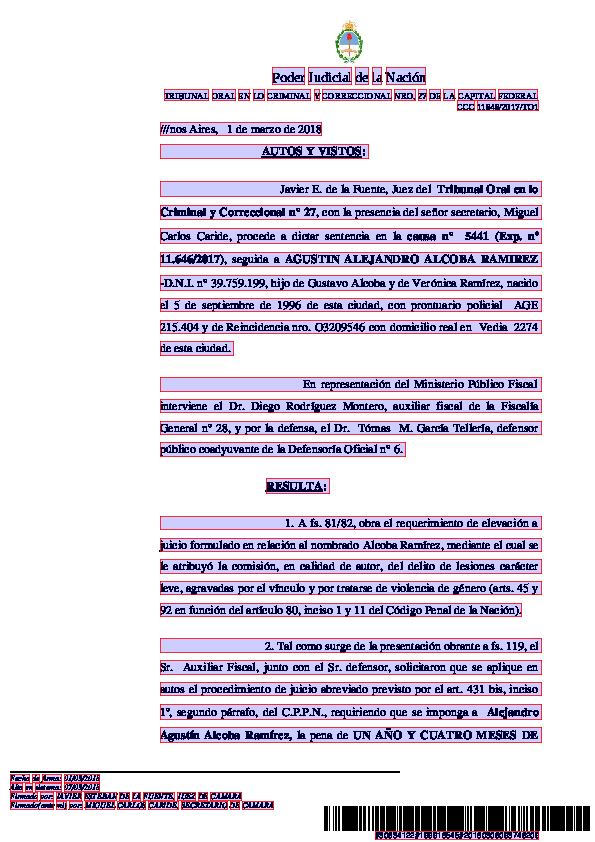

In [35]:
im = first_page.to_image()
im.draw_rects(first_page.extract_words())

In [37]:
texto = [page.extract_text() for page in pdf.pages]
print(texto)

['Poder Judicial de la Nación\nTRIBUNAL ORAL EN LO CRIMINAL Y CORRECCIONAL NRO. 27 DE LA CAPITAL FEDERAL\nCCC 11646/2017/TO1\n///nos\xa0Aires,\xa0\xa0\xa01\xa0de\xa0marzo\xa0de\xa02018\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0AUTOS\xa0Y\xa0VISTOS:\xa0\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Javier\xa0E.\xa0de\xa0la\xa0Fuente,\xa0Juez\xa0del\xa0Tribunal\xa0Oral\xa0en\xa0lo\xa0\nCriminal\xa0y\xa0Correccional\xa0n°\xa027,\xa0con\xa0la\xa0presencia\xa0del\xa0señor\xa0secretario,\xa0Miguel\xa0\nCarlos\xa0Caride,\xa0procede\xa0a\xa0dictar\xa0sentencia\xa0en\xa0la\xa0causa\xa0n°\xa0\xa05441\xa0(Exp.\xa0nº\xa0\n11.646/2017),\xa0seguida\xa0a\xa0AGUSTIN\xa0ALEJANDRO\xa0ALCOBA\xa0RAMIREZ\xa0\n\xadD.N.I.\xa0n°\xa039.759.199,\xa0hijo\xa0de\xa0Gustavo\xa0Alcoba\xa0y\xa0de\xa0Verónica\xa0Ramírez,\xa0nacido\

In [0]:
words_dict = []
for page in pdf.pages:
    words_dict.extend(page.extract_words())

In [0]:
words = [elem['text'] for elem in words_dict]

In [42]:
serie = pd.Series(words)
serie

0                                      Poder
1                                   Judicial
2                                         de
3                                         la
4                                     Nación
                       ...                  
489                                  CARIDE,
490                               SECRETARIO
491                                       DE
492                                   CAMARA
493    #30634122#199918545#20180306093746209
Length: 494, dtype: object

In [43]:
serie.value_counts()

DE                                                                                   28
por:                                                                                 16
CAMARA                                                                               16
de                                                                                   12
LA                                                                                   12
                                                                                     ..
C.P  y arts. 403, 530 y 531 del C.P.P.N.).                                            1
Ello ocurrió el día 21 de febrero de 2017, siendo                                     1
Agustín Alcoba Ramírez, la pena de UN AÑO Y CUATRO MESES DE                           1
la C.S.J.N. (fs. 9/10), en el que se destacó que se trataría de una situación de      1
///nos Aires,   1 de marzo de 2018                                                    1
Length: 222, dtype: int64